## Conditional probability of aerial survey

Are surveys more likely in a year following mortality? Let $X_{i,j}$ denote a mortality observation for a pixel $i$ at time $j$. We are interested in whether

$$
\frac{P(X_{i,j+1} = \mathrm{nan}|X_{i,j}=0)}{P(X_{i,j+1} = \mathrm{nan}|X_{i,j} \geq 1)} \neq 1.
$$

The null hypothesis is that this ratio is 1, while the alternative hypothesis is that the ratio is greater than one (i.e. future surveys are more likely when a pixel is observed with mortality).

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

mort = xr.open_dataset("../mort_datasets/westmort.nc")["mortality"].sel(time=slice(2001, None))
mort

<xarray.DataArray 'mortality' (time: 23, y: 652, x: 590)> Size: 35MB
[8847640 values with dtype=float32]
Coordinates:
  * x        (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y        (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * time     (time) int64 184B 2001 2002 2003 2004 2005 ... 2020 2021 2022 2023

Only consider pixels that are not entirely nan and that had some mixture of mortality and no-mortality observations. This doesn't matter as far as getting a test statistic but makes running permutation tests a lot faster.

In [2]:
valid_y, valid_x = np.where((mort.mean(dim="time") > 0).data)

y_selector = xr.DataArray(mort.y.data[valid_y], dims=["pixel"])
x_selector = xr.DataArray(mort.x.data[valid_x], dims=["pixel"])

mort_valid_px = mort.sel(x=x_selector, y=y_selector)

In [3]:
mort_valid_px

<xarray.DataArray 'mortality' (time: 23, pixel: 79972)> Size: 7MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ...,  5.,  5.,  0.],
       [ 0.,  0.,  0., ...,  0.,  5., nan],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan,  0., ..., 20.,  0., nan],
       [nan, nan, nan, ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
    x        (pixel) float64 640kB -1.366e+07 -1.366e+07 ... -1.227e+07
    y        (pixel) float64 640kB 6.274e+06 6.274e+06 ... 3.678e+06 3.678e+06
  * time     (time) int64 184B 2001 2002 2003 2004 2005 ... 2020 2021 2022 2023
Dimensions without coordinates: pixel

Baby example.

Text(0.5, 1.0, 'Mortality time series per pixel')

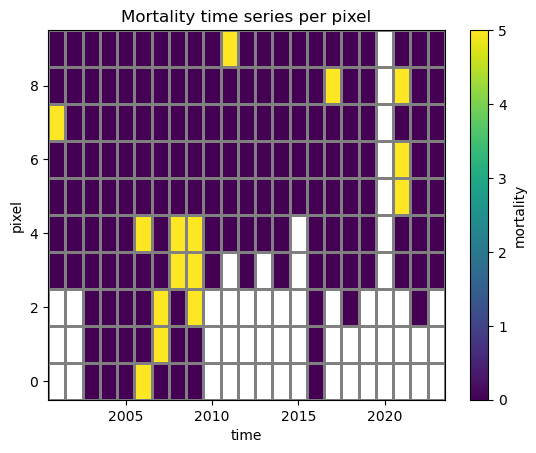

In [4]:
small = mort_valid_px.isel(pixel=slice(None, 10)).transpose()
small.plot(edgecolors="gray")
plt.title("Mortality time series per pixel")

<xarray.DataArray 'mortality' ()> Size: 4B
array(0.08181818, dtype=float32)


Text(0.5, 1.0, 'Unsurveyed with no prior mortality')

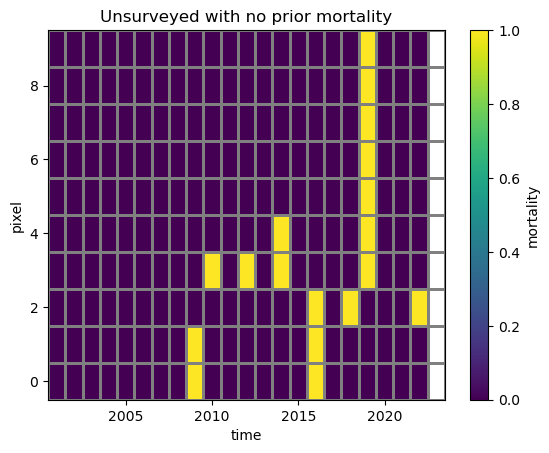

In [5]:
small_null = small.isnull()
small_no_prior_mort = (small == 0).shift(time=1).astype(bool)

null_and_no_mort = (small_null & small_no_prior_mort).shift(time=-1).astype(np.float32)
print(null_and_no_mort.mean())
null_and_no_mort.plot(edgecolors="gray")
plt.title("Unsurveyed with no prior mortality")

<xarray.DataArray 'mortality' ()> Size: 4B
array(0.00454545, dtype=float32)


Text(0.5, 1.0, 'Unsurveyed with prior mortality')

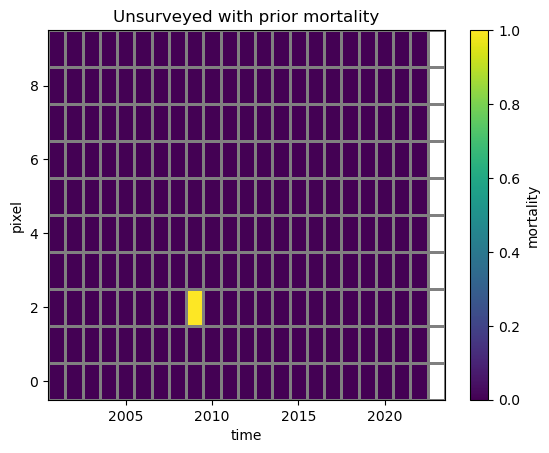

In [6]:
small = mort_valid_px.isel(pixel=slice(None, 10)).transpose()
small_null = small.isnull()
small_yes_prior_mort = (small > 0).shift(time=1).astype(bool)

null_and_yes_mort = (small_null & small_yes_prior_mort).shift(time=-1).astype(np.float32)
print(null_and_yes_mort.mean())
null_and_yes_mort.plot(edgecolors="gray")
plt.title("Unsurveyed with prior mortality")

In [7]:
print((small.isel(time=slice(None, -1)) == 0).mean())

<xarray.DataArray 'mortality' ()> Size: 8B
array(0.7)


In [8]:
print((small.isel(time=slice(None, -1)) > 0).mean())

<xarray.DataArray 'mortality' ()> Size: 8B
array(0.06818182)


In [9]:
p_aub = null_and_no_mort.mean()
p_auc = null_and_yes_mort.mean()
p_b   = (small.isel(time=slice(None, -1)) == 0).mean()
p_c   = (small.isel(time=slice(None, -1)) >  0).mean()

print( (p_aub/p_b) * (p_c / p_auc))

<xarray.DataArray 'mortality' ()> Size: 8B
array(1.75324673)


Calculate overall test statistic.

In [10]:
mort_null = mort_valid_px.isnull()
no_prior_mort = (mort_valid_px == 0).shift(time=1).astype(bool)
yes_prior_mort = (mort_valid_px > 0).shift(time=1).astype(bool)

null_and_yes_mort = (mort_null & yes_prior_mort).shift(time=-1).astype(np.float32)
null_and_no_mort  = (mort_null & no_prior_mort).shift(time=-1).astype(np.float32)

# Mean calculation ignores the row of nulls introduced at the last time step
p_null_and_yes_mort = null_and_yes_mort.mean().data
p_null_and_no_mort  = null_and_no_mort.mean().data

p_no_mort = (mort_valid_px.isel(time=slice(None, -1)) == 0).mean()
p_yes_mort = (mort_valid_px.isel(time=slice(None, -1)) > 0).mean()

S = (p_null_and_no_mort / p_no_mort) * (p_yes_mort / p_null_and_yes_mort)
print(S)

<xarray.DataArray 'mortality' ()> Size: 8B
array(1.85172567)


Write as a function for permutation testing.

In [11]:
def get_likelihood_ratio(arr):
    arr_null = arr.isnull()
    no_prior_mort = (arr == 0).shift(time=1).astype(bool)
    yes_prior_mort = (arr > 0).shift(time=1).astype(bool)
    
    null_and_yes_mort = (arr_null & yes_prior_mort).shift(time=-1).astype(np.float32)
    null_and_no_mort  = (arr_null & no_prior_mort).shift(time=-1).astype(np.float32)
    
    # Mean calculation ignores the row of nulls introduced at the last time step
    p_null_and_yes_mort = null_and_yes_mort.mean().data
    p_null_and_no_mort  = null_and_no_mort.mean().data
    
    p_no_mort = (arr.isel(time=slice(None, -1)) == 0).mean()
    p_yes_mort = (arr.isel(time=slice(None, -1)) > 0).mean()
    
    S = (p_null_and_no_mort / p_no_mort) * (p_yes_mort / p_null_and_yes_mort)
    return S.data

In [12]:
# Should get exact same result with original array
test_stat = get_likelihood_ratio(mort_valid_px)
print(test_stat)

1.8517256716152664


In [13]:
# Now copy the array, shuffle it, and see what the ratio is.
# It should be one, since shuffling would remove any temporal
# autocorrelation in the data.
from tqdm.autonotebook import tqdm

def run_trial():
    mort_copy = mort_valid_px.data.copy().flatten()
    np.random.shuffle(mort_copy)
    mort_copy = mort_copy.reshape(mort_valid_px.shape)
    
    # Turn it back into a data array (although tbh just doing this
    # with numpy arrays might be easier.
    mort_copy_arr = xr.DataArray(
        mort_copy,
        dims=mort_valid_px.dims,
        coords=mort_valid_px.coords
    )
    return get_likelihood_ratio(mort_copy_arr)

n_trials = 500
ratios = np.zeros(n_trials)
for i in tqdm(range(n_trials)):
    ratios[i] = run_trial()

/tmp/ipykernel_347/1207342944.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/500 [00:00<?, ?it/s]

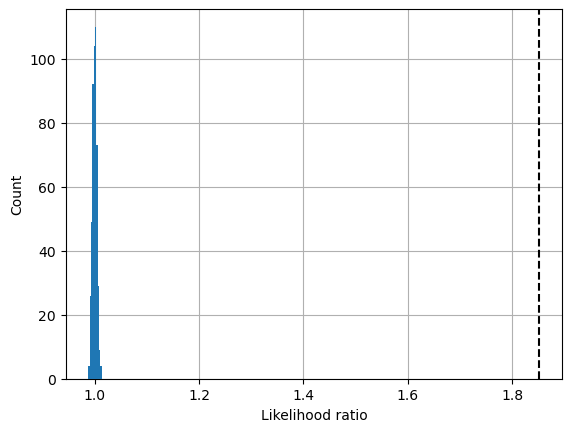

In [14]:
plt.xlabel("Likelihood ratio")
plt.ylabel("Count")
plt.grid(zorder=0)
plt.hist(ratios, zorder=3)
plt.axvline(test_stat, color="black", linestyle="--", zorder=3)
plt.show()

Conclusion: pixels with no mortality are ~10% more likely to not be surveyed the following year than pixels with mortality.